# Preprocessing

Implement the preprocessing and justify the preprocessing steps

**Resize, grayscale & normalization**

In [39]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to collect all images from a folder (including subfolders)
def collect_images_from_folder(folder_path):
    image_paths = []
    # Walk through all subfolders and gather image file paths
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Add conditions for image file types if necessary
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Function to preprocess the images (resize, grayscale, and normalize)
def preprocess_images(image_paths, image_size=(128, 128)):
    processed_images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize(image_size)  # Resize
        img_array = np.array(img_resized) / 255.0  # Normalize to [0, 1]
        processed_images.append(img_array)
    return np.array(processed_images)


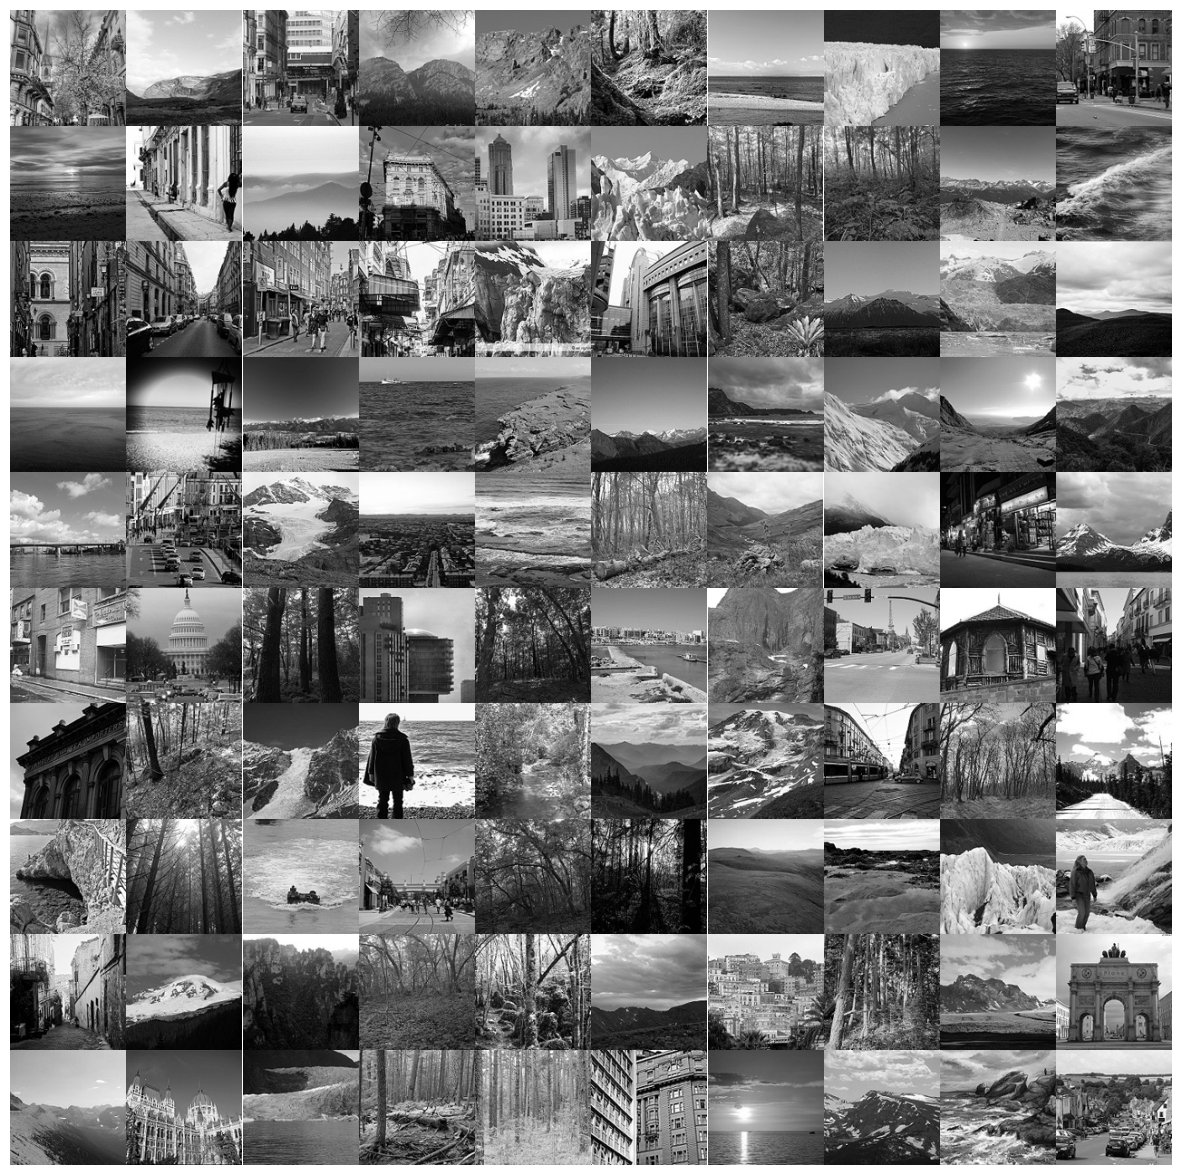

In [40]:
# Folder containing the images
folder_path = 'intel-image-classification'  # Update with your folder path

# Collect all image paths
image_paths = collect_images_from_folder(folder_path)

# Preprocess images
images = preprocess_images(image_paths)
# Display the first 100 preprocessed images
fig, axs = plt.subplots(10, 10, figsize=(15, 15), gridspec_kw={'wspace': 0, 'hspace': 0})

for i, ax in enumerate(axs.ravel()):
    if i < len(images[:100]):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

# Extract features

Extract features and justify the methods used 

In [41]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from torchviz import make_dot
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, CategoricalCrossentropy
from keras.metrics import BinaryAccuracy, SparseCategoricalAccuracy, CategoricalAccuracy
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import backend as K
import math
from keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

seed = 0

In [42]:
base_lr = 0.0075
final_lr = 0.0
warmup_epochs = 10
total_epochs = 75
bs = 24
max_update = total_epochs

In [ ]:
import os
import random
import shutil

# Stier til trenings- og valideringsmapper
train_dir = 'intel-image-classification/seg_train/seg_train'  # Original treningsmappe med bilder kategorisert
val_dir = 'intel-image-classification/seg_val/seg_val'  # Mappe for valideringsdata

# Opprett valideringsmappen hvis den ikke finnes
os.makedirs(val_dir, exist_ok=True)

# Gå gjennom hver kategori i treningsmappen
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    
    # Sjekk om det er en mappe (kategori)
    if os.path.isdir(category_path):
        # Opprett tilsvarende undermappe for denne kategorien i valideringsmappen
        val_category_path = os.path.join(val_dir, category)
        os.makedirs(val_category_path, exist_ok=True)

        # Hent alle bildefiler i denne kategorien
        images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]

        # Bland bildene tilfeldig og beregn antall bilder for validering (20%)
        random.shuffle(images)
        num_validation = int(len(images) * 0.2)

        # Del opp i validerings- og treningsbilder
        validation_images = images[:num_validation]

        # Flytt valideringsbilder til valideringsmappen
        for img in validation_images:
            src_path = os.path.join(category_path, img)
            dest_path = os.path.join(val_category_path, img)
            shutil.move(src_path, dest_path)

print("20 prosent av bildene er flyttet til valideringsmappen.")


'\nimport os\nimport random\nimport shutil\n\n# Stier til trenings- og valideringsmapper\ntrain_dir = \'intel-image-classification/seg_train/seg_train\'  # Original treningsmappe med bilder kategorisert\nval_dir = \'intel-image-classification/seg_val/seg_val\'  # Mappe for valideringsdata\n\n# Opprett valideringsmappen hvis den ikke finnes\nos.makedirs(val_dir, exist_ok=True)\n\n# Gå gjennom hver kategori i treningsmappen\nfor category in os.listdir(train_dir):\n    category_path = os.path.join(train_dir, category)\n    \n    # Sjekk om det er en mappe (kategori)\n    if os.path.isdir(category_path):\n        # Opprett tilsvarende undermappe for denne kategorien i valideringsmappen\n        val_category_path = os.path.join(val_dir, category)\n        os.makedirs(val_category_path, exist_ok=True)\n\n        # Hent alle bildefiler i denne kategorien\n        images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]\n\n        # Bland bildene 

In [44]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'intel-image-classification/seg_train/seg_train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'intel-image-classification/seg_val/seg_val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'intel-image-classification/seg_test/seg_test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import load_model

model = Sequential()

# Input layer som forventer bilder i størrelse 150x150x3
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3), name="conv_layer1"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", name="conv_layer2"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", name="conv_layer3"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())  # Flater ut data for fullt tilkoblede lag

# Fullt tilkoblede lag
model.add(Dense(64, activation="relu", name="dense_layer1"))
model.add(Dense(32, activation="relu", name="dense_layer2"))

# Output layer for flerkategoriklassifisering med 6 kategorier
model.add(Dense(6, activation="softmax", name="output"))

# Kompiler modellen
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

model.summary()


C:\Users\Anine Løkken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer1 (Conv2D)            │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer3 (Conv2D)            │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer1 (Dense)            │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer2 (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,463,078 (9.40 MB)

 Trainable params: 2,463,078 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

model.save("model.h5")

Epoch 1/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 313s 879ms/step - categorical_accuracy: 0.4241 - loss: 1.4098 - val_categorical_accuracy: 0.5977 - val_loss: 1.0191
Epoch 2/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 224s 637ms/step - categorical_accuracy: 0.6032 - loss: 1.0153 - val_categorical_accuracy: 0.6715 - val_loss: 0.8753
Epoch 3/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 215s 611ms/step - categorical_accuracy: 0.6556 - loss: 0.9018 - val_categorical_accuracy: 0.7197 - val_loss: 0.7892
Epoch 4/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 212s 602ms/step - categorical_accuracy: 0.6902 - loss: 0.8319 - val_categorical_accuracy: 0.7586 - val_loss: 0.6702
Epoch 5/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 225s 639ms/step - categorical_accuracy: 0.7152 - loss: 0.7705 - val_categorical_accuracy: 0.7093 - val_loss: 0.7820
Epoch 6/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 224s 639ms/step - categorical_accuracy: 0.7228 - loss: 0.7456 - val_categorical_accuracy: 0.7800 - val_loss: 0.6320
Epoch 7/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 220s 627ms/step - catego

Test accuracy: 0.8479999899864197


In [53]:
model = load_model("model.h5")

In [54]:
# Gjør prediksjoner på alle testbilder i generatoren
predictions = model.predict(test_generator)

# Få de predikerte klassene
predicted_classes = np.argmax(predictions, axis=1)

# Hent de faktiske klassene fra generatoren
true_classes = test_generator.classes

# Sammenlign prediksjoner med sanne verdier
accuracy = np.mean(predicted_classes == true_classes)
print(f"Modellens nøyaktighet på testsettet: {accuracy * 100:.2f}%")


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step
Modellens nøyaktighet på testsettet: 16.50%


In [56]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_single_image(model, image_path, class_names, true_class=None):
    """
    Tester et enkelt bilde på modellen, skriver ut den predikerte klassen,
    sannsynligheter for hver klasse, og (valgfritt) faktisk klasse hvis kjent.
    
    Args:
        model: Den trenede Keras-modellen.
        image_path: Filstien til bildet som skal testes.
        class_names: Liste med navn på hver klasse, i riktig rekkefølge.
        true_class: (valgfritt) Den faktiske klassenavn for bildet.
    """
    # Last opp og preprocess bildet
    img = load_img(image_path, target_size=(150, 150))  # Tilpass til modellens input-størrelse
    img_array = img_to_array(img) / 255.0  # Normaliser bildet
    img_array = np.expand_dims(img_array, axis=0)  # Legg til batch-dimensjon

    # Prediker med modellen
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    predicted_prob = predictions[0][predicted_index]

    # Skriv ut resultatene
    print(f"Predikert klasse: {predicted_class} (Sannsynlighet: {predicted_prob:.2f})")
    
    # Hvis vi har en faktisk klasse, kan vi vise det
    if true_class is not None:
        print(f"Faktisk klasse: {true_class}")
        if true_class == predicted_class:
            print("Modellen predikerte riktig!")
        else:
            print("Modellen predikerte feil.")


In [57]:
# Definer klassenavnene i riktig rekkefølge
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

folder = 'mountain'
image_number = '20129'
image_path = f"intel-image-classification/seg_test/seg_test/{folder}/{image_number}.jpg"

# Test et enkelt bilde og angi den faktiske klassen for sammenligning
test_single_image(model, image_path, class_names, true_class=folder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Predikert klasse: mountain (Sannsynlighet: 0.94)
Faktisk klasse: mountain
Modellen predikerte riktig!


In [58]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_random_images_from_each_category(model, base_dir, class_names, num_images=10):
    """
    Tester `num_images` tilfeldige bilder fra hver kategori i `base_dir` og beregner nøyaktigheten.
    
    Args:
        model: Den trenede Keras-modellen.
        base_dir: Rotstien til testbildene (f.eks. 'intel-image-classification/seg_test/seg_test').
        class_names: Liste med navn på hver kategori (klassenavn).
        num_images: Antall bilder som skal testes fra hver kategori.
    """
    correct_predictions = 0
    total_predictions = 0
    
    print("\nTesting tilfeldige bilder fra hver kategori:\n")
    
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        all_images = os.listdir(class_dir)
        
        # Velg 10 tilfeldige bilder fra hver kategori
        selected_images = random.sample(all_images, min(num_images, len(all_images)))
        
        for image_name in selected_images:
            image_path = os.path.join(class_dir, image_name)
            
            # Last opp og preprocess bildet
            img = load_img(image_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)  # Legg til batch-dimensjon
            
            # Prediker klassen
            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions)
            predicted_class = class_names[predicted_index]
            
            # Sammenlign prediksjonen med den faktiske klassen
            is_correct = predicted_class == class_name
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            # Skriv ut resultatene
            print(f"Bilde: {image_path}")
            print(f" - Faktisk klasse: {class_name}")
            print(f" - Predikert klasse: {predicted_class}")
            print(f" - {'Riktig' if is_correct else 'Feil'}\n")
    
    # Beregn nøyaktighet
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"Total nøyaktighet: {accuracy * 100:.2f}% ({correct_predictions}/{total_predictions} riktige prediksjoner)")

In [59]:
# Rotmappe til testbildene
base_dir = 'intel-image-classification/seg_test/seg_test'

# Klassenavn i riktig rekkefølge
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Kall metoden
test_random_images_from_each_category(model, base_dir, class_names, num_images=10)


Testing tilfeldige bilder fra hver kategori:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Bilde: intel-image-classification/seg_test/seg_test\buildings\23692.jpg
 - Faktisk klasse: buildings
 - Predikert klasse: buildings
 - Riktig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Bilde: intel-image-classification/seg_test/seg_test\buildings\22637.jpg
 - Faktisk klasse: buildings
 - Predikert klasse: buildings
 - Riktig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Bilde: intel-image-classification/seg_test/seg_test\buildings\23932.jpg
 - Faktisk klasse: buildings
 - Predikert klasse: buildings
 - Riktig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Bilde: intel-image-classification/seg_test/seg_test\buildings\23338.jpg
 - Faktisk klasse: buildings
 - Predikert klasse: street
 - Feil

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Bilde: intel-image-classification/seg_test/seg_test\buildings\20926.jpg
 - Faktisk klasse: buildings
 - Predikert klasse: buildings
 - Riktig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Bilde: intel-

# Bruke ResNet for å hente ut features

In [60]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from torchvision import models, transforms

In [2]:
# Load ResNet50 model pre-trained on ImageNet
resnet = ResNet50(weights='imagenet', include_top=False)  # Exclude final classification layer

In [3]:
def preprocess_image(img):
    img = tf.image.resize(img, (64, 64))
    img = preprocess_input(img)  # This applies the same normalization
    return img

In [13]:
# Assuming images are loaded as a NumPy array or a list of file paths
def load_and_preprocess_images(image_paths):
    processed_images = []
    for img_path in image_paths:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = preprocess_image(img)
        processed_images.append(img)
    return tf.stack(processed_images)

image_paths = collect_images_from_folder('intel-image-classification/seg_train/seg_train')
images = load_and_preprocess_images(image_paths)

In [14]:
# Extract features
features = resnet.predict(images)
features = features.reshape(features.shape[0], -1)  # Flatten each feature map

np.save("features.npy", features)

351/351 ━━━━━━━━━━━━━━━━━━━━ 139s 382ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


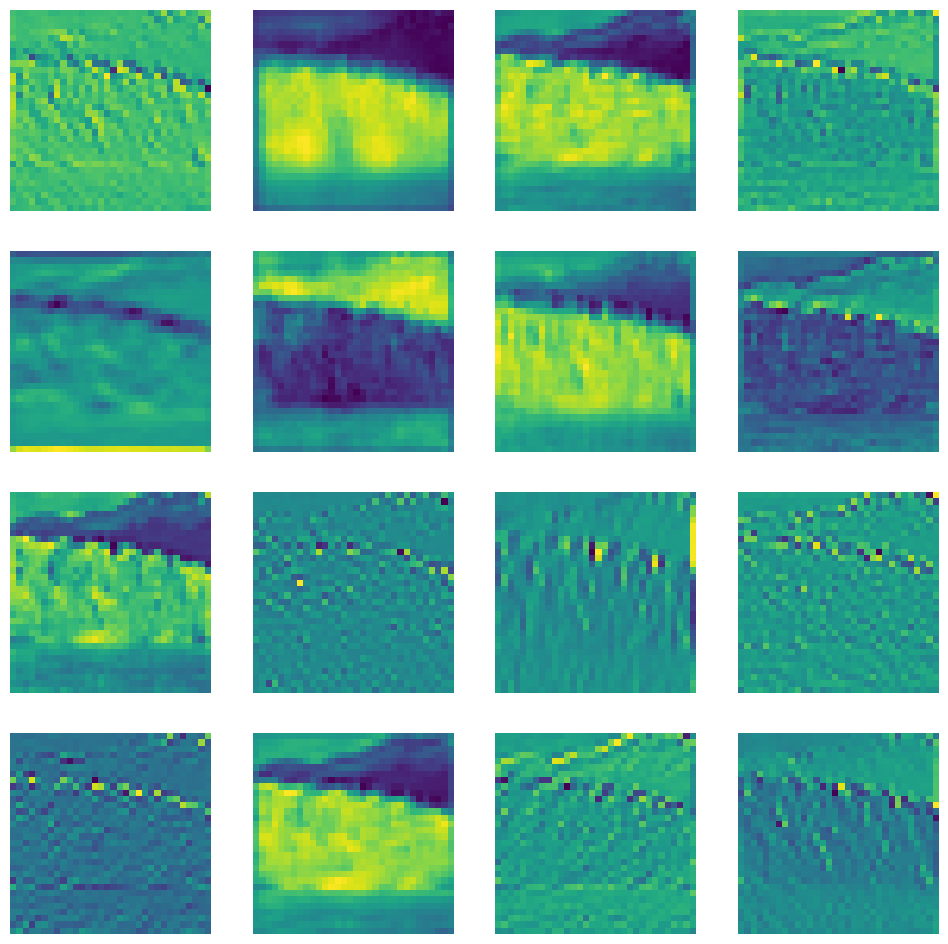

In [15]:
# Load model and create a feature extractor
base_model = ResNet50(weights='imagenet', include_top=False)
layer_name = 'conv1_conv'  # The name of the layer you want to visualize
model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Preprocess and load an image
img = tf.keras.preprocessing.image.load_img("intel-image-classification/seg_test/seg_test/glacier/20059.jpg", target_size=(64, 64))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, axis=0)
img = tf.keras.applications.resnet50.preprocess_input(img)

# Generate feature maps
feature_maps = model.predict(img)

# Visualize the first 16 feature maps
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < feature_maps.shape[-1]:
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
    ax.axis("off")
plt.show()

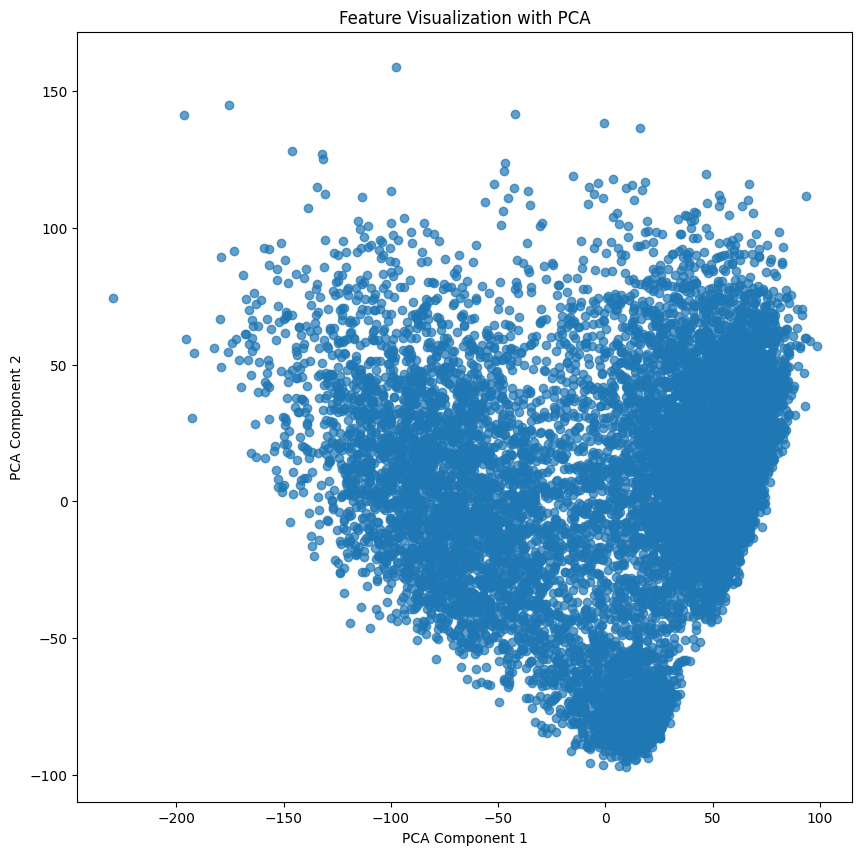

In [16]:
# Assuming `features` is a [num_images, feature_size] array of extracted features
# Example: features = model.predict(dataset)

# Apply PCA or t-SNE
pca = PCA(n_components=2)  # For 2D visualization
# tsne = TSNE(n_components=2)  # Alternative with t-SNE

reduced_features = pca.fit_transform(features)

# Plot the reduced features
plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Feature Visualization with PCA")
plt.show()

TypeError: Invalid shape (224, 224, 7) for image data

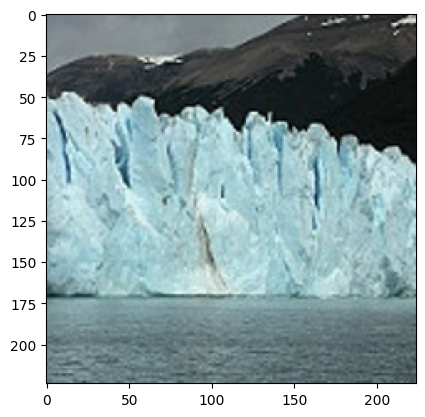

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import cv2  # For resizing the cam heatmap to overlay on the original image

# Load model and set to evaluation
model = models.resnet50(pretrained=True)
model.eval()

# Load and preprocess the image
image = Image.open("intel-image-classification/seg_test/seg_test/glacier/20059.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)

# Variables to store gradients and layer outputs
gradients = []
layer_outputs = []

# Hook to capture gradients of the chosen layer
def save_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# Hook to capture the forward output (feature map) of the chosen layer
def save_layer_output(module, input, output):
    layer_outputs.append(output)

# Choose a layer to hook into
layer = model.layer4[2].conv3  # Example layer in ResNet
handle_grad = layer.register_backward_hook(save_gradient)
handle_output = layer.register_forward_hook(save_layer_output)

# Forward pass
output = model(image)
pred_class = output.argmax().item()

# Backward pass for the chosen class
model.zero_grad()
output[0, pred_class].backward()

# Get the gradients and the feature map
grads = gradients[0].detach().cpu().numpy()
feature_map = layer_outputs[0].detach().cpu().numpy()[0]  # Take the first batch

# Calculate Grad-CAM heatmap
weights = np.mean(grads, axis=(1, 2))  # Average the gradients over spatial dimensions
cam = np.sum(weights[:, None, None] * feature_map, axis=0)  # Weighted sum over channels

# Normalize and resize cam to match the image
cam = np.maximum(cam, 0)  # Apply ReLU to keep positive values only
cam = cam / cam.max()  # Normalize to [0, 1]
cam = cv2.resize(cam, (224, 224))  # Resize to match the input image size

# Convert the image back to original format for display
original_image = Image.open("intel-image-classification/seg_test/seg_test/glacier/20059.jpg").convert('RGB')
original_image_resized = original_image.resize((224, 224))
plt.imshow(original_image_resized)
plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay Grad-CAM heatmap
plt.axis('off')
plt.show()

# Remove the hooks
handle_grad.remove()
handle_output.remove()


# Naïve Bayes

In [61]:
import os
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.transform import resize

In [62]:
def load_images_from_folder(folder, img_size=(64, 64)):
    images = []
    labels = []
    for label in os.listdir(folder):
        category_path = os.path.join(folder, label)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                try:
                    img = imread(img_path, as_gray=True)  # Les inn i gråtoner for enkelhet
                    img = resize(img, img_size)          # Endre størrelse for konsistens
                    images.append(img.flatten())         # Flat ut bildet til en vektor
                    labels.append(label)                 # Bruk mappenavnet som label
                except:
                    print(f"Kunne ikke lese bildet {img_path}")
    return np.array(images), np.array(labels)

# Last inn trenings- og valideringssett
train_folder = f"intel-image-classification\seg_train\seg_train"
val_folder = f"intel-image-classification\seg_val\seg_val"

X_train, y_train = load_images_from_folder(train_folder)
X_val, y_val = load_images_from_folder(val_folder)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anine Løkken\AppData\Local\Temp\ipykernel_7888\1155184065.py:19: SyntaxWarning: invalid escape sequence '\s'
  train_folder = f"intel-image-classification\seg_train\seg_train"
C:\Users\Anine Løkken\AppData\Local\Temp\ipykernel_7888\1155184065.py:20: SyntaxWarning: invalid escape sequence '\s'
  val_folder = f"intel-image-classification\seg_val\seg_val"


In [63]:
# Initialiser klassifikatoren
model = GaussianNB()

# Tren modellen
model.fit(X_train, y_train)

GaussianNB()

In [64]:
# Gjør prediksjoner på valideringssettet
y_pred = model.predict(X_val)

# Beregn nøyaktigheten
accuracy = accuracy_score(y_val, y_pred)
print(f"Valideringsnøyaktighet: {accuracy * 100:.2f}%")

Valideringsnøyaktighet: 42.51%


In [ ]:
test_folder = 'intel-image-classification\seg_test\seg_test'
X_test, y_test = load_images_from_folder(test_folder)
X_test = scaler.transform(X_test)

# Gjør prediksjoner på testsettet
y_test_pred = model.predict(X_test)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anine Løkken\AppData\Local\Temp\ipykernel_25892\3811417952.py:1: SyntaxWarning: invalid escape sequence '\s'
  test_folder = 'intel-image-classification\seg_test\seg_test'


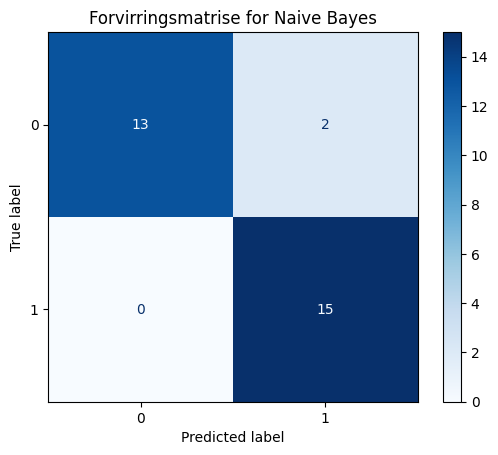

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gjør prediksjoner
y_pred = model.predict(X_test)

# Beregn og plot forvirringsmatrisen
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Forvirringsmatrise for Naive Bayes")
plt.show()


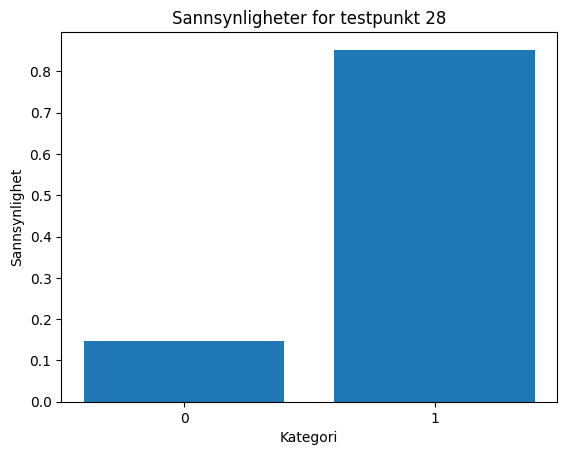

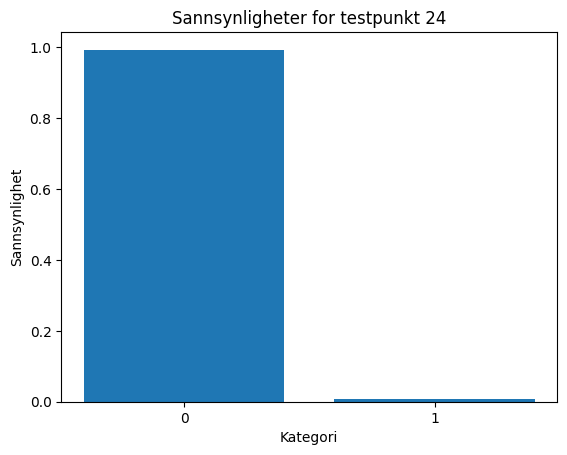

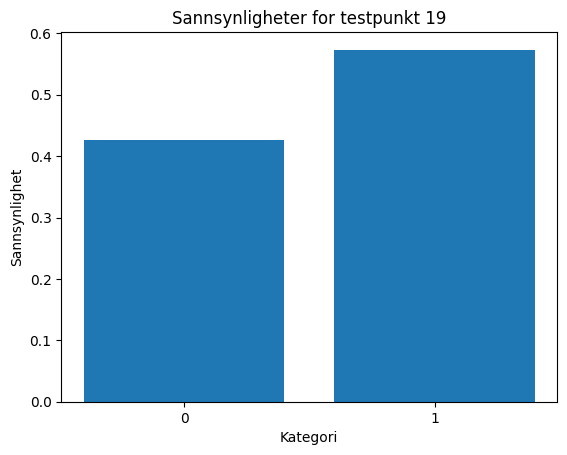

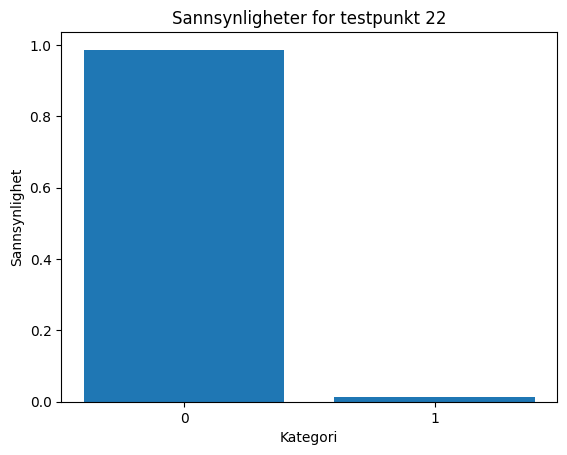

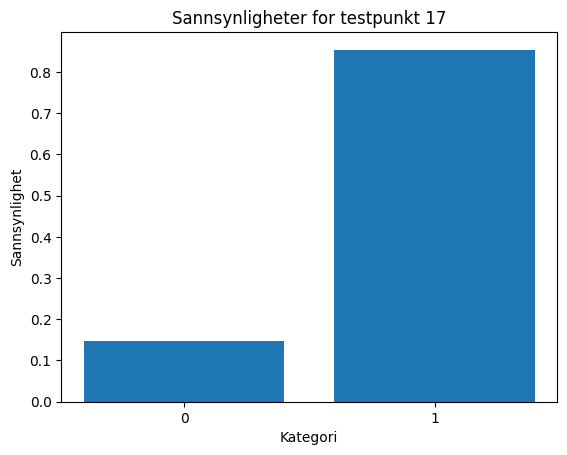

In [65]:
import numpy as np
sample_indices = np.random.choice(len(X_test), size=5, replace=False)
sample_probs = model.predict_proba(X_test[sample_indices])

for i, probs in enumerate(sample_probs):
    plt.bar(range(len(probs)), probs, tick_label=model.classes_)
    plt.title(f"Sannsynligheter for testpunkt {sample_indices[i]}")
    plt.xlabel("Kategori")
    plt.ylabel("Sannsynlighet")
    plt.show()
